1. Check whether decoding latent vectors that are drawn from the prior distribution yields reasonable sequences.
2. Check whether we can accurately reconstruct sequences after encoding them (i.e. encode sequence, then decode back, then check whether we get something close to what we started with)

## Preliminaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
from modules_gd.model import VAE
# help(VAE)
# help(MSA_Dataset)

In [2]:
MSA_id = "PF00565"
data_path = f"data/Ding/processed/{MSA_id}"

Load binarized MSA

In [3]:
## read multiple sequence alignment in binary representation
with open(f"{data_path}/seq_msa_binary.pkl", 'rb') as file_handle:
    msa_binary = torch.tensor(pickle.load(file_handle))
# for some reason, msa_binary is float64 so first transform it to float 32 for later use
msa_binary = msa_binary.to(torch.float32)
# Number of sequences
n_total = msa_binary.shape[0]
# Dimensions of one-hot encoding
nl = msa_binary.shape[1]
nc = msa_binary.shape[2]
# Print shape
msa_binary.shape

torch.Size([7907, 103, 21])

Load model

In [4]:
model_name = "model_2024-05-06.pt"
model_path = f"saved_models/{MSA_id}/{model_name}"
model = VAE(nl = nl, nc = nc, dim_latent_vars=2) # initiate to have the right architecture for loading
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Load mapping between integers and amino acid characters

In [5]:
with open(f"{data_path}/aa_index.pkl", 'rb') as file_handle:
    aa_index = pickle.load(file_handle)

# now let's create the inverse mapping
# In our integer encoding of proteins, we've encoded several different amino acid characters as 0
# For decoding purposes, we will decode all 0's as '-'
del aa_index['.'], aa_index['X'], aa_index['B'], aa_index['Z'], aa_index['J'], 


idx_to_aa_dict = {}
for k, v in aa_index.items():
    idx_to_aa_dict[v] = k

# Part 1: Decoding draws from the prior

In [6]:
# draws from the prior to be decoded
# z has to be a torch.tensor with a size of (num_seqs, dim_latent_space)
num_seqs = 25
dim_latent_space = model.dim_latent_vars
z = torch.randn(num_seqs, dim_latent_space)

# decode to amino acid probabilities
with torch.no_grad():
    log_p = model.decoder(z)
    p = torch.exp(log_p)
p = p.numpy()
p.shape

(25, 103, 21)

In [7]:
# covert probablities into actual protein sequences by choosing the most likely amino acid at each position.
max_prob_idx = np.argmax(p, -1)
seqs = []
for i in range(num_seqs):
    seq = [idx_to_aa_dict[idx] for idx in max_prob_idx[i,:]]
    print("".join(seq))
    seqs.append("".join(seq))

VNLSSIRAPRLGNPRRPPEPFAREAKEFLRTRLIGRQVTVEMEYSDRVGMVFGSVFLGGQNVAELLLARGFAEVSRHYERSHYYDALVAAESRAKAAKKGL..
LLLAGIKAPRTGRPDGPAEPFGDEAKQFVETRLLQRNVKVTLLGTSQSGVPIGNVLHPGGNIAEKLLENGLAEVVDWQSGSGGMSKLRKAEKTAKAKGKGLWK
ITLSSIMAPRLARRGGTDEPFAWESREFLRKLCIGKEVTFRVEYTANSGREFGTVYLGEENVAKLVVAEGWAKVKEQGQVSPYVTELLRLEEQAKDQGKGRWS
.MLSGIRCPGFKLDADVKVPFAEEARYFVESRLLQRDVEIILESV.NNNNFVGTILHPKGNIAEALLKEGFAKCVDSSAMKSGAEKLRAAERIAKEKRLRLWK
VRLIGIDAPETKQ.RKPPEPYGKEAKDYLKKLCGKKTVVVEEFDKDKYGRLLAYVYVGGLDVNEELVEQGLAVAYRKYGNVRYRDEYVKAEEKARAARRGIWS
LVLSGIRAPGSKRNPNKSEPFGQEAHDFVEKRLLQRDVEIRVESVDKNGGFIGTLYYNKENIAEILLKEGLATCHEYSAQKGHANELYAAEKKAKEARLGLWK
.KVAGIKCPQPARHGAPAEPFGEEAKLFTRRHVMQRNVEVEVEDMDRGGNAFGPLFLVGTNFGVRLLEAGLAWVDSASVRTAYYQQLQRAEEKAKAQKKNYWS
IRLAGIDTPETDKPGNPGQPFAKEAKKFVEDLLLNRKVTVKVLGIDQYGRALALVYVGGNNVSEELLKNGLAEVYDGQGYGSKMSKLRKAEQTAKAKKKGIWS
..LSGVQCPRKEVDNNGPEPFAREAKFFVESRLLNRDVEVVLEGVDKNGNLYGSVLHPLGNIALELLKNGLAKINDWSIEAEAALKYRNAEKEAKQKRLRLWK
VRLIGIDTPETK....PPEPYGKEAADLLKKLLPKGSVVRLEFDVDKYGRLLAYVYVAGLCINE

Now let's compare to some real sequences. 

To do so, first let's retrieve an integer encoded version of the MSA (instead of binary). We have pickled such an encoding with file name `seq_msa.pkl`

In [8]:
with open(f"{data_path}/seq_msa.pkl", 'rb') as file_handle:
    real_seqs_int = torch.tensor(pickle.load(file_handle))
# Alternatively, since `argmax` works for extracting position of the 1 from the one hot encoded vectors:
real_seqs_int2 = torch.argmax(msa_binary, -1)
assert real_seqs_int.equal(real_seqs_int2)
print(real_seqs_int.shape)

torch.Size([7907, 103])


Now we can decode the integers to amino acid characters using `idx_to_aa_dict`.

In [9]:
real_seqs = []
for i in range(n_total):
    seq = [idx_to_aa_dict[idx] for idx in real_seqs_int[i,:]]
    real_seqs.append("".join(seq))
for seq in real_seqs:
    print(seq)

VMLSGVKCPSFKREADTPEPFAAEAKFFTESRLLQRDVQIIL.ESCPNQIILGTILHPNGNITELLLKEGFARCVDSMAYTQGAEKLRAAERSAKERKVRIWK
IHLSSIRPPRLEGEGTYDIPYMFEAREFLRKKLIGKKVNVTVDYIAFSERTCATVAIGGINIAEALVSKGLATVIRYRQRSSHYDELLAAEARAIKNGKGLHS
IHLSSIRPPRLEGESAYDIPYMFEAREFLRKKLIGKKVNVTVDYISFSERTCATVSIGGINIAEALISKGLSTVIRYRQRSSHYDELLAAEARAIKNGKGLHS
VNLSSIRSPKMGNPRRKPAPYAREAKEFLRTRLIGQKVSVSMEYSDSKLMDFGSVFLVGPNVGELIVSRGFGTVIRHRDRSNHYDALLAAESRANSGKKGIH.
FVLGGIRAPKSARGPNKAEPFGQEAHDLATKRLTQRDVEVDVHSIDKVGGFIGELYINKESFAKILVEEGFATVHVYSAQAGNATELLGAEQRAKDARRGLWV
VTLAATRSPRAAAITNKSEELGDVARFFTESRLLHQDVTVSLLGLTSNTPFVATVTHAQGNIAAFLLQGGLARIVDHAGGPEEMGALRRAEADAKAAKKGIWH
VMLSGIKCPTFKREADVPEPFAAEAKFFTESRLLQRDVQIV.LESCHNQNILGTILHPNGNITELLLKEGFARCVDSIAYTRGADKLRAAERFAKERKLRIWR
VKVAGVITPQTAFNPRTADPLSEEAKNFVIRLVQQREVNVQVYTSDRGGNFISAVTLKGTNLSVALVEAGFATVGNADR.LPFCQQLADAEDEARSAGLNIWA
..IAGIRTPATERTLPPAEEYGNEARSFVESRLLQRKIKVEIVGASAQGQLVATLIHPRGNIAEFLLQEGLARCNDFHSLGERMAALRAAEKQAQSKKLRL..
FSLAYVTAPRLSKDGD..EPYAFQSREFLRELTLGKPIKCTVLYTPNSGREYGIAQLQGTELPE

What's the proportion of characters that match?

In [10]:
correct = 0
total = 0
for (seq, real_seq) in zip(seqs, real_seqs[:num_seqs]):
  correct += sum([real_c == recon_c for (real_c, recon_c) in zip(seq, real_seq)])
  total += len(seq)
print(f"correct: {correct}")
print(f"total: {total}")
print(f"Percentage correct: {np.round(100*correct/total, 2)}")

correct: 848
total: 2575
Percentage correct: 32.93


# Part 2: Reconstructing sequences

Now let's not just draw from the prior and decode, but draw from the posterior defined by a given real sequence and then decode. In other words, let's see whether our VAE is good at reconstructing sequences:

First, we encode the real sequences

In [11]:
with torch.no_grad():
  mu, sigma = model.encoder(msa_binary)
mu.shape, sigma.shape

(torch.Size([7907, 2]), torch.Size([7907, 2]))

We can view the `mu` vectors as embeddings of the proteins. Let's plot them:

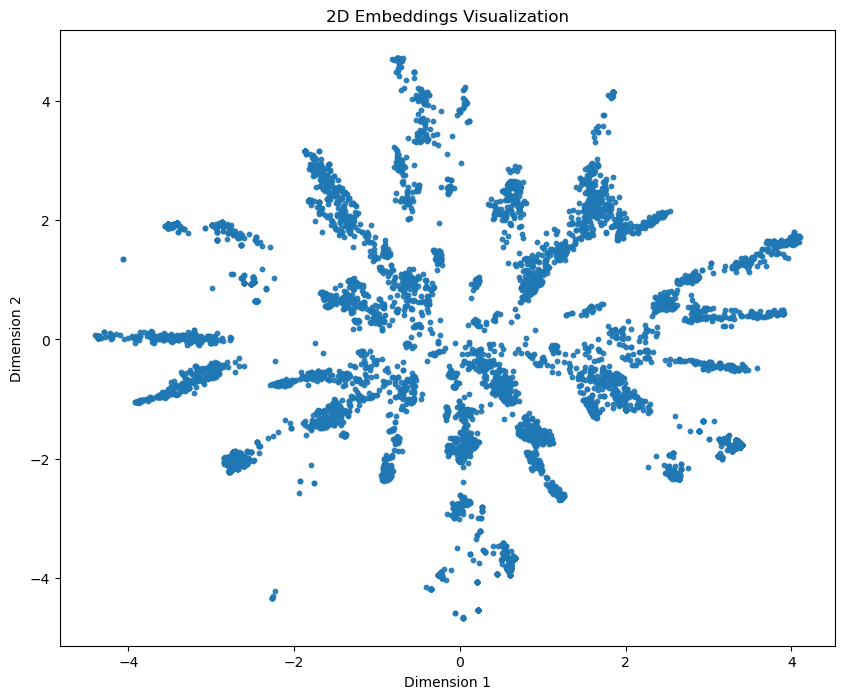

In [12]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(mu[:, 0], mu[:, 1], s=10, alpha=0.9)

# Add axis labels
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Add a title
plt.title('2D Embeddings Visualization')

# Show the plot
plt.show()

Let's save them to a csv

In [13]:
# Convert to dataframe
embeddings = pd.DataFrame(mu.numpy(), columns=["dim1", "dim2"])
# Add names of sequences as a column
with open(f"{data_path}/seq_names.pkl", 'rb') as file_handle:
    seq_names = pickle.load(file_handle)
embeddings.insert(0, "id", seq_names)
# Save to csv
model_name = model_name.split(".")[0]
embeddings.to_csv(f"embeddings/{MSA_id}/{model_name}_embeddings.csv", index=False)

Now we decode the $\mu$'s

In [14]:
with torch.no_grad():
  log_p = model.decoder(mu)
  p = torch.exp(log_p)
p.shape

torch.Size([7907, 103, 21])

Now we covert probablities into actual protein sequences by choosing the most likely amino acid at each position.


In [15]:
max_prob_idx = torch.argmax(p, -1)

To check accuracy, i.e. the percentage of amino acids that match, we can simply run

In [16]:
# Proportion of amino acids correctly recovered
torch.sum(real_seqs_int == max_prob_idx)/real_seqs_int.nelement()

tensor(0.7994)

Alternatively, we can decode the integer `max_prob_idx` to character 

In [17]:
recon_seqs = []
for i in range(len(max_prob_idx)):
    recon_seq = [idx_to_aa_dict[idx] for idx in max_prob_idx[i,:]]
    recon_seqs.append("".join(recon_seq))

In [18]:
real_seqs[:100]

['VMLSGVKCPSFKREADTPEPFAAEAKFFTESRLLQRDVQIIL.ESCPNQIILGTILHPNGNITELLLKEGFARCVDSMAYTQGAEKLRAAERSAKERKVRIWK',
 'IHLSSIRPPRLEGEGTYDIPYMFEAREFLRKKLIGKKVNVTVDYIAFSERTCATVAIGGINIAEALVSKGLATVIRYRQRSSHYDELLAAEARAIKNGKGLHS',
 'IHLSSIRPPRLEGESAYDIPYMFEAREFLRKKLIGKKVNVTVDYISFSERTCATVSIGGINIAEALISKGLSTVIRYRQRSSHYDELLAAEARAIKNGKGLHS',
 'VNLSSIRSPKMGNPRRKPAPYAREAKEFLRTRLIGQKVSVSMEYSDSKLMDFGSVFLVGPNVGELIVSRGFGTVIRHRDRSNHYDALLAAESRANSGKKGIH.',
 'FVLGGIRAPKSARGPNKAEPFGQEAHDLATKRLTQRDVEVDVHSIDKVGGFIGELYINKESFAKILVEEGFATVHVYSAQAGNATELLGAEQRAKDARRGLWV',
 'VTLAATRSPRAAAITNKSEELGDVARFFTESRLLHQDVTVSLLGLTSNTPFVATVTHAQGNIAAFLLQGGLARIVDHAGGPEEMGALRRAEADAKAAKKGIWH',
 'VMLSGIKCPTFKREADVPEPFAAEAKFFTESRLLQRDVQIV.LESCHNQNILGTILHPNGNITELLLKEGFARCVDSIAYTRGADKLRAAERFAKERKLRIWR',
 'VKVAGVITPQTAFNPRTADPLSEEAKNFVIRLVQQREVNVQVYTSDRGGNFISAVTLKGTNLSVALVEAGFATVGNADR.LPFCQQLADAEDEARSAGLNIWA',
 '..IAGIRTPATERTLPPAEEYGNEARSFVESRLLQRKIKVEIVGASAQGQLVATLIHPRGNIAEFLLQEGLARCNDFHSLGERMAALRAAEKQAQSKKLRL..',
 'FSLAYVTAPRLSKDGD..EPYAFQSR

In [19]:
recon_seqs[:100]

['VMLSGVKCPTFKREADTPEPFAAEAKFFTESRLLQRDVQIIL.ESCPNQIILGTILHPNGNITELLLKEGFARCVDSMAYTQGAEKLRAAERSAKERKVRIWK',
 'IHLSSIRPPRLEGESKYDIPYMFEAREFLRKKLIGKKVNVTVDYIAFSERTCATVTIGGINIAEALVSKGLATVIRYRQRSSHYDELLAAEARAIKNGKGLHS',
 'IHLSSIRPPRLEGESKYDIPYMFEAREFLRKKLIGKKVNVTVDYIAFSERTCATVTIGGINIAEALVSKGLATVIRYRQRSSHYDELLAAEARAIKNGKGLHS',
 'VNLSSIRCPKMGNPRRKPAPYAREAKEFLRTRLIGKQVNVSMEYSDSRVMDFGSVFLPGVNVAELLLSRGFGTVIRHRDRSNHYDALLAAESRAISGKKGIH.',
 'LVLGGIRAPRSARNPGKGEPFGQEAHDFANRRCMQRDVEIDVETIDKVGGFIGTLYVNRENFAKILVEEGLATVHAYSAQSGHANELFAAEKKAKEARKGLWH',
 'LLLAGIKAPRSARPDGPAEPFGEEAKFFVESRLLQRNVKVTLLGLSPSGVFIGTVLHPAGNIAEFLLAAGLARVVDWHSGGGGMEKLRQAEKTAKEKRLGLWK',
 'VMLSGIKCPTFRREADTPEPFAAEAKFFTESRLLQRDVQII.LESCHNQNILGTILHPNGNITELLLKEGFARCVDSIAYTRGAEKLRAAERFAKERRLRIWR',
 '.KVAGIKCPQPARRGATAEPFGEEAKLFTRRHVQQRNVEVEVEDMDRGGNAFGPLFLGGTNFGVALLEAGLATVDNADRRTPYAQQLQRAEEKAKAAKKKYWS',
 '..LAGIRTPATERTLPPAEEYGNEARAFVEQRLLQRQVKVEIVGASPQGQLVASVIHPRGNIAEFLLQEGLARCNDFHSLGEKMAPLRAAEKQAQGKKLRL..',
 'LSLAYVSAPRLRREGD..EPFAFQSR

and then run

In [20]:
correct = 0
total = 0
for (recon_seq, real_seq) in zip(recon_seqs, real_seqs):
  correct += sum([real_c == recon_c for (real_c, recon_c) in zip(recon_seq, real_seq)])
  total += len(real_seq)
print(f"correct: {correct}")
print(f"total: {total}")
print(f"Percentage correct: {np.round(100*correct/total, 2)}")

correct: 651026
total: 814421
Percentage correct: 79.94
